Genutzte Bias mitigations:

-SMOTE
- Spalten droppen (gender, native-country, race, relationship, fnlwgt)
- marital-status mit married_group (married, unmarried) ersetzt.
- Aufsplitten in Trainings und Test Daten mit Strategied Sampling    (stratify=df_income["income"])
- Cost-Sensitive Learning beim Trainingsprozess (class_weight="balanced")
---

# Startup
- Imports
- Dataset einlesen

#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_sample_weight


from imblearn.over_sampling import SMOTE

from pandas.api.types import CategoricalDtype

#### Dataset einlesen

In [2]:
df_income = pd.read_csv("adult.csv")

# Daten aufbereiten
- income zu 0 und 1
- Features relationship & marital-status ausgeben
- marital-status zusammenfassen (zu married und unmarried als married_group)

#### income-Spalte von "<=50k" & ">50k" -> "0" & "1" | "Binär kodieren"

In [3]:
df_income['income'] = df_income['income'].str.strip().map({'<=50K':0, '>50K':1})

#### Features relationship & marital-status ausgeben

In [4]:
df_income["relationship"].unique()

array(['Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife',
       'Other-relative'], dtype=object)

In [5]:
df_income["marital-status"].unique()

array(['Never-married', 'Married-civ-spouse', 'Widowed', 'Divorced',
       'Separated', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

#### marital-status zusammenfassen (zu married und unmarried als **married_group**)

In [6]:
married_values = [
    "Married-civ-spouse",
    "Married-spouse-absent",
    "Married-AF-spouse"
]

df_income["married_group"] = df_income["marital-status"].apply(
    lambda x: "Married" if x in married_values else "Unmarried"
)

# Datensatz Analyse
- Mengenanzahl-Ausgabe des zusammengefassten-features married_group
- Mengenanzahl-Ausgabe der Einträge von <=50k und >50k
- Geschlechterverteilung & Einkommen pro Geschlecht
- Altersverteilung und Einkommen pro Alter
- Herrkunft & Einkommen pro Herrkunft
- Hautfarbe & Einkommen pro Hautfarbe
- Heatmap aller Features

#### Mengenanzahl-Ausgabe des zusammengefassten-features **married_group**

In [7]:
df_income["married_group"].value_counts()

,count
married_group,
Unmarried,25798
Married,23044


#### Mengenanzahl-Ausgabe der Einträge von <=50k und >50k

In [8]:
counts = df_income["income"].value_counts()
for val, count in counts.items():
    label = "<=50K" if val == 0 else ">50K"
    print(f"{label}: {count} Einträge")

<=50K: 37155 Einträge
>50K: 11687 Einträge


#### Geschlechterverteilung & Einkommen pro Geschlecht

Geschlechterverteilung:

gender
Male      32650
Female    16192
Name: count, dtype: int64


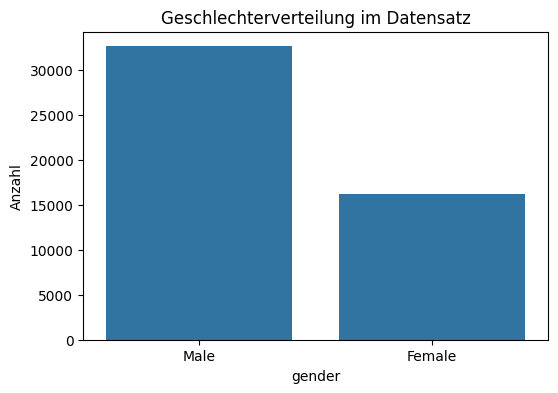


Prozentuale Verteilung von <=50K / >50K pro Geschlecht:

income          0          1
gender                      
Female  89.074852  10.925148
Male    69.623277  30.376723


<Figure size 600x400 with 0 Axes>

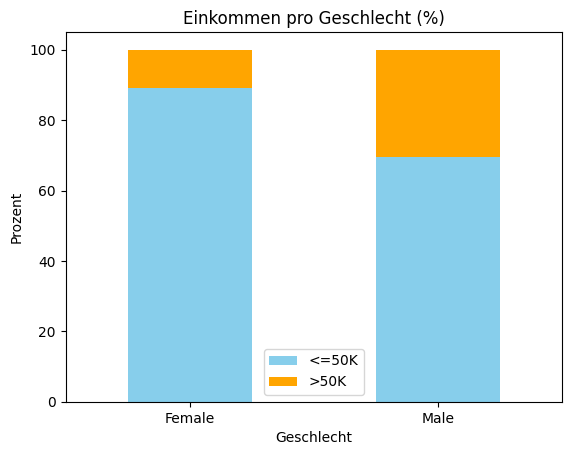

In [9]:
# Geschlechterverteilung
gender_counts = df_income["gender"].value_counts()
print("Geschlechterverteilung:\n")
print(gender_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=gender_counts.index, y=gender_counts.values)
plt.title("Geschlechterverteilung im Datensatz")
plt.ylabel("Anzahl")
plt.show()

# Geschlechterverteilung + Einkommen

gender_income = pd.crosstab(df_income["gender"], df_income["income"], normalize='index') * 100
print("\nProzentuale Verteilung von <=50K / >50K pro Geschlecht:\n")
print(gender_income)

plt.figure(figsize=(6,4))
gender_income.plot(kind='bar', stacked=True, color=['skyblue','orange'])
plt.title("Einkommen pro Geschlecht (%)")
plt.ylabel("Prozent")
plt.xlabel("Geschlecht")
plt.legend(["<=50K", ">50K"])
plt.xticks(rotation=0)
plt.show()

#### Altersverteilung und Einkommen pro Alter





Altersverteilung:



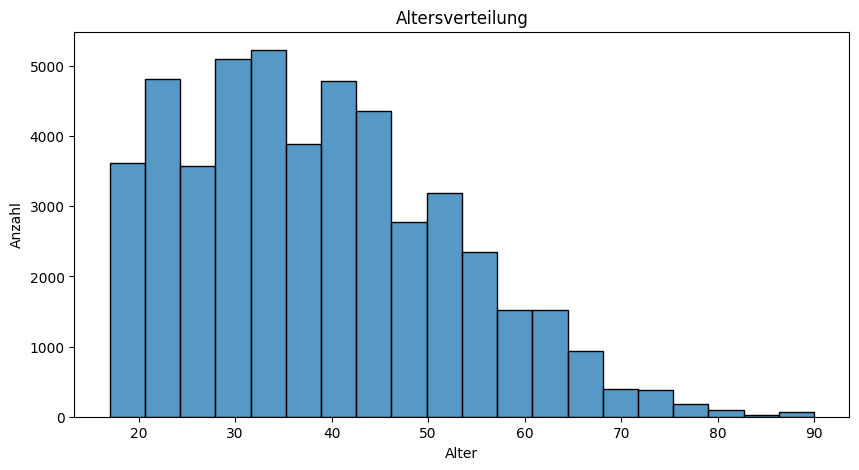


Altersverteilung & Einkommen



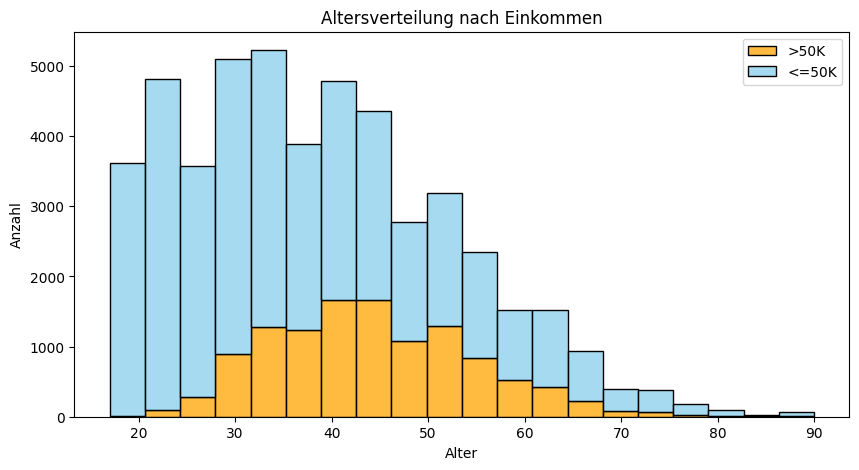

In [10]:
# Altersverteilung
print("\n\n\n\nAltersverteilung:\n")
plt.figure(figsize=(10,5))
sns.histplot(df_income["age"], bins=20, kde=False)
plt.title("Altersverteilung")
plt.xlabel("Alter")
plt.ylabel("Anzahl")
plt.show()

# Altersverteilung + Einkommen
print("\nAltersverteilung & Einkommen\n")
plt.figure(figsize=(10,5))
sns.histplot(df_income, x="age", hue="income", multiple="stack", bins=20, palette=['skyblue','orange'])
plt.title("Altersverteilung nach Einkommen")
plt.xlabel("Alter")
plt.ylabel("Anzahl")
plt.legend([">50K", "<=50K"])
plt.show()

#### Herrkunft & Einkommen pro Herrkunft





Herrkunft:

Top 10 Herkunftsländer:

native-country
United-States    43832
Mexico             951
?                  857
Philippines        295
Germany            206
Puerto-Rico        184
Canada             182
El-Salvador        155
India              151
Cuba               138
Name: count, dtype: int64


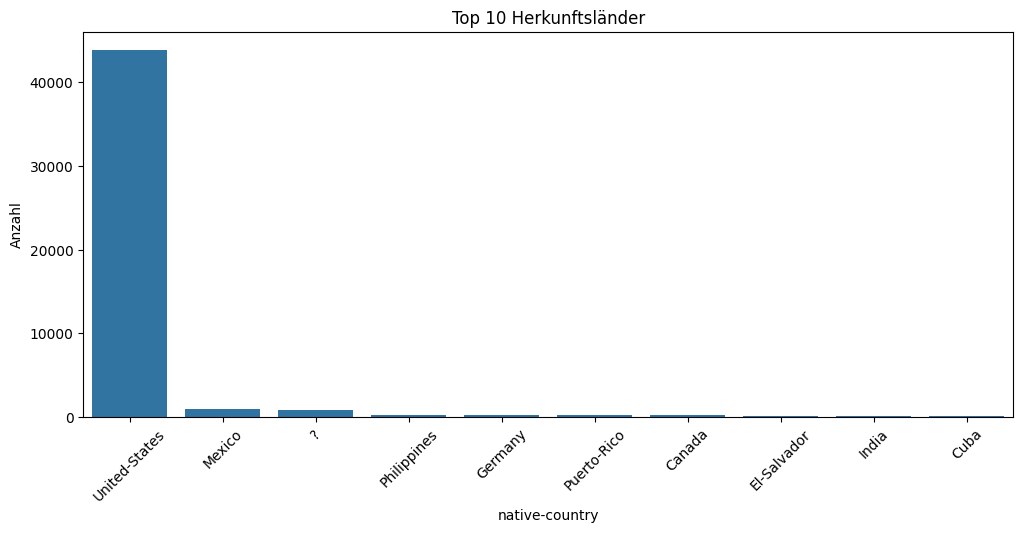

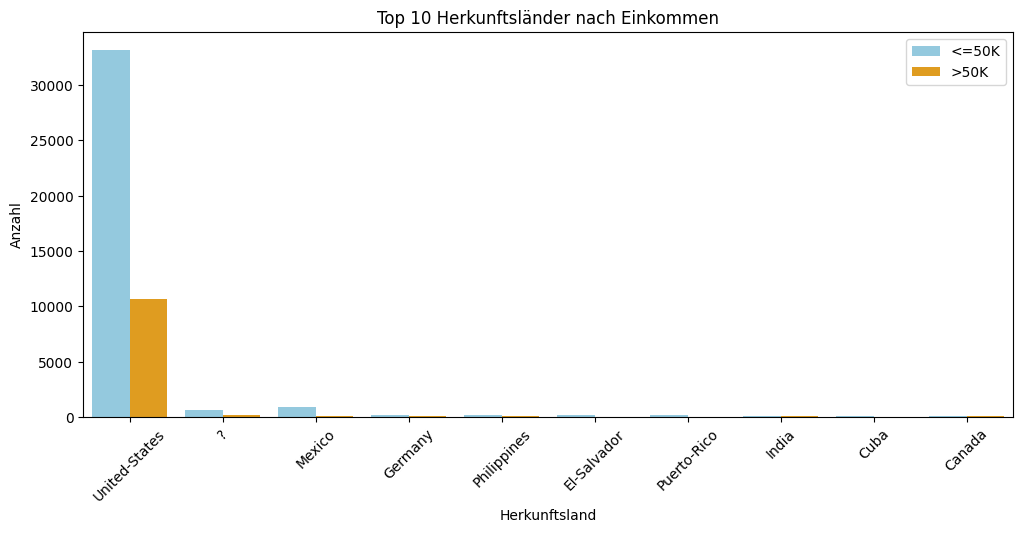

Anteil an Personen pro Land, die >50K Einkommen haben (absteigend):
native-country
France                        42.105263
India                         41.059603
Taiwan                        40.000000
Iran                          37.288136
England                       37.007874
Greece                        36.734694
Japan                         34.782609
Yugoslavia                    34.782609
Canada                        34.615385
Italy                         32.380952
Cambodia                      32.142857
Hungary                       31.578947
Ireland                       29.729730
China                         29.508197
Philippines                   28.813559
Germany                       28.155340
Hong                          26.666667
?                             25.670945
Cuba                          24.637681
United-States                 24.397700
Poland                        19.540230
Portugal                      17.910448
South                         17.3913

In [11]:
# Herkunft (native-country)
print("\n\n\n\nHerrkunft:\n")
country_counts = df_income["native-country"].value_counts().sort_values(ascending=False)
print("Top 10 Herkunftsländer:\n")
print(country_counts.head(10))

plt.figure(figsize=(12,5))
sns.barplot(x=country_counts.head(10).index, y=country_counts.head(10).values)
plt.title("Top 10 Herkunftsländer")
plt.ylabel("Anzahl")
plt.xticks(rotation=45)
plt.show()

# Herkunft (native-country) + Einkommen
top_countries = country_counts.head(10).index
plt.figure(figsize=(12,5))
sns.countplot(data=df_income[df_income["native-country"].isin(top_countries)],
              x="native-country", hue="income", palette=['skyblue','orange'])
plt.title("Top 10 Herkunftsländer nach Einkommen")
plt.ylabel("Anzahl")
plt.xlabel("Herkunftsland")
plt.xticks(rotation=45)
plt.legend(["<=50K", ">50K"])
plt.show()

#____

# Prozentualer Anteil von Leuten, die >50K verdienen, pro Land ausgeben

# Prozentualer Anteil >50K Einkommen pro Land (alle Länder) errechnen
income_pct_all = pd.crosstab(df_income["native-country"], df_income["income"], normalize='index') * 100
income_pct_all = income_pct_all[1]  # nur >50K

# Absteigend sortieren
income_pct_all = income_pct_all.sort_values(ascending=False)

print("Anteil an Personen pro Land, die >50K Einkommen haben (absteigend):")
print(income_pct_all)


#### Hautfarbe & Einkommen pro Hautfarbe

Hautfarben

race
White                 41762
Black                  4685
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      470
Other                   406
Name: count, dtype: int64


/tmp/ipython-input-544724408.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=race_counts.index, y=race_counts.values, palette="pastel")


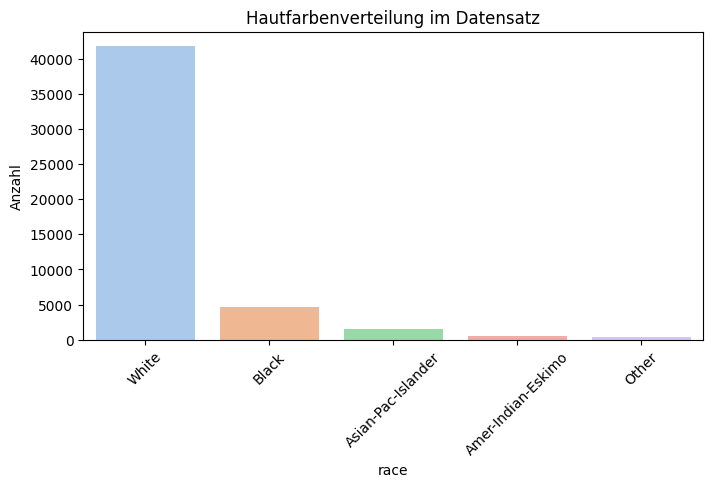


Rassen & Einkommen

income                      0          1
race                                    
Amer-Indian-Eskimo  88.297872  11.702128
Asian-Pac-Islander  73.074391  26.925609
Black               87.918890  12.081110
Other               87.684729  12.315271
White               74.601312  25.398688


<Figure size 1000x500 with 0 Axes>

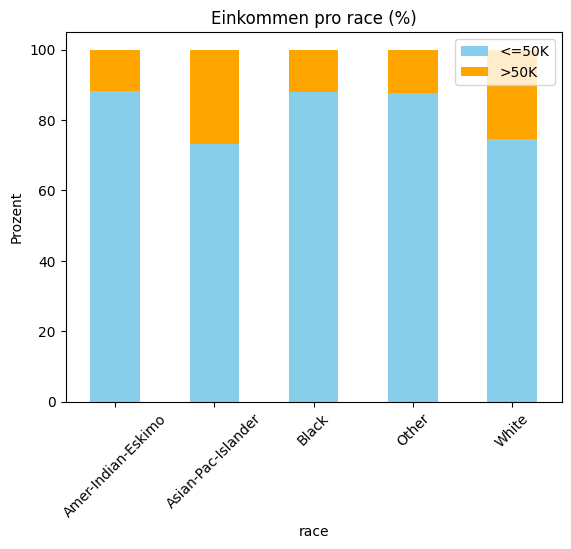

In [12]:
# Hautfarben
print("Hautfarben\n")
race_counts = df_income["race"].value_counts()
print(race_counts)

plt.figure(figsize=(8,4))
sns.barplot(x=race_counts.index, y=race_counts.values, palette="pastel")
plt.title("Hautfarbenverteilung im Datensatz")
plt.ylabel("Anzahl")
plt.xlabel("race")
plt.xticks(rotation=45)
plt.show()

# Hautfarbenverteilung + Einkommen
print("\nRassen & Einkommen\n")
race_income = pd.crosstab(df_income["race"], df_income["income"], normalize='index') * 100
print(race_income)

plt.figure(figsize=(10,5))
race_income.plot(kind='bar', stacked=True, color=['skyblue','orange'])
plt.title("Einkommen pro race (%)")
plt.ylabel("Prozent")
plt.xlabel("race")
plt.xticks(rotation=45)
plt.legend(["<=50K", ">50K"])
plt.show()

#### Heatmap

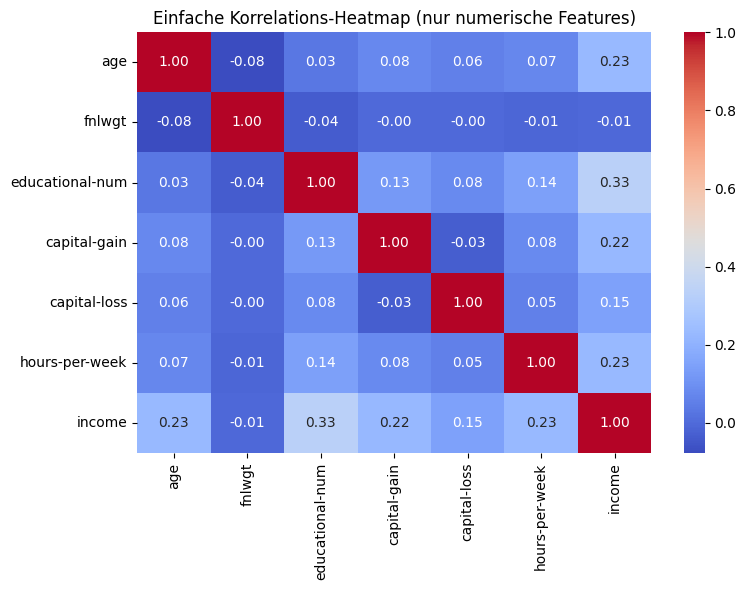

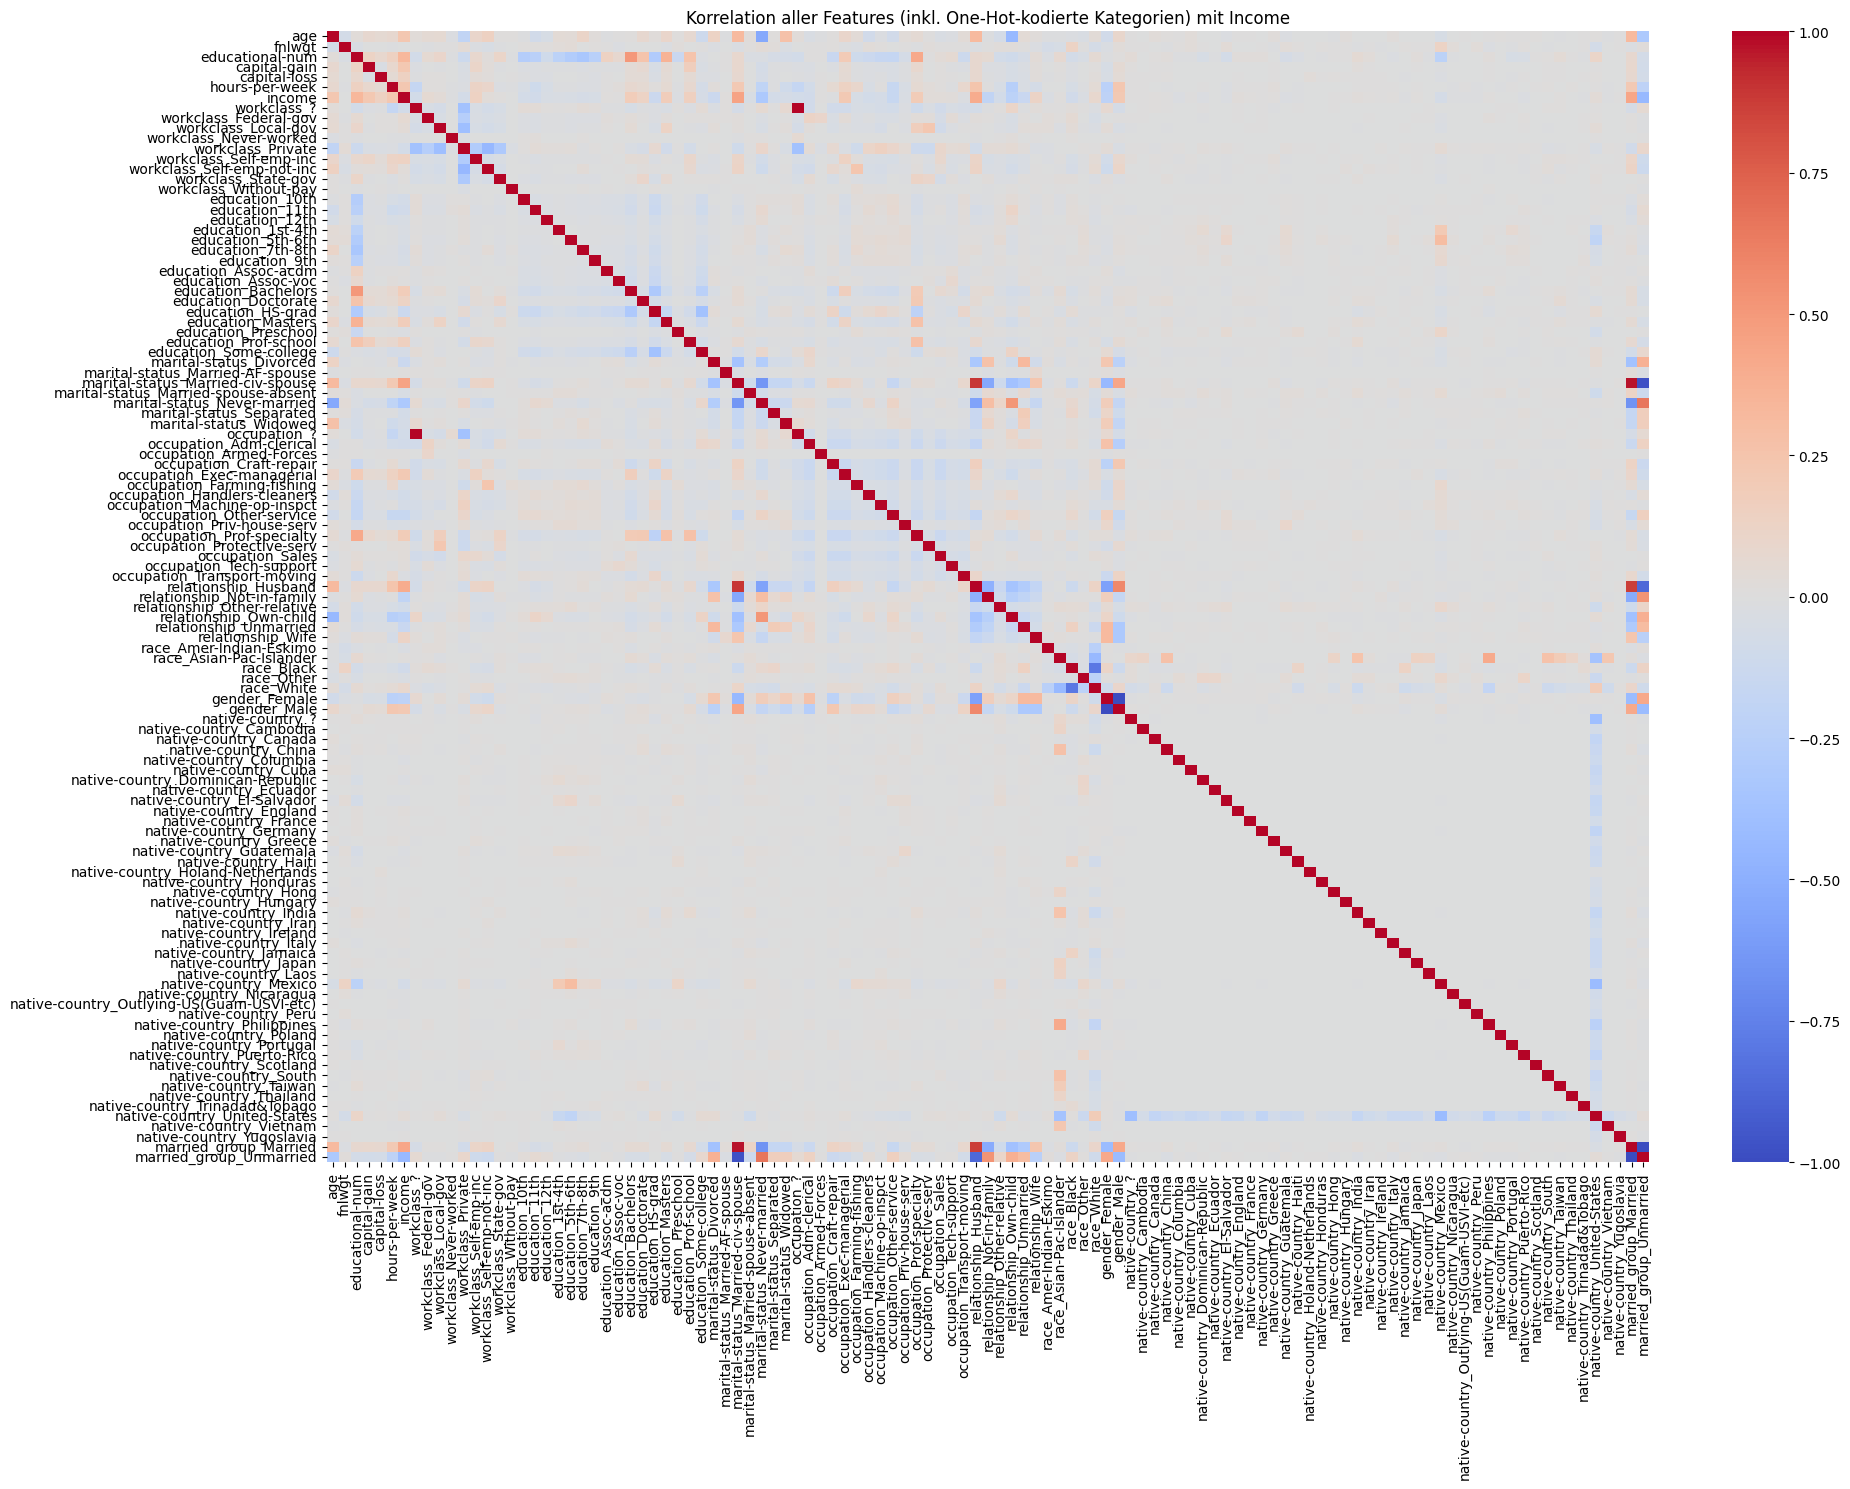

In [13]:
#SIMPLE HEATMAP
# Nur numerische Spalten (keine Strings, keine Kategorien)
num_df = df_income.select_dtypes(include=["int64", "float64"])

# Korrelation berechnen
corr = num_df.corr()

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Einfache Korrelations-Heatmap (nur numerische Features)")
plt.tight_layout()
plt.show()



# GESAMTE HEATMAP
# Alle kategorischen Features identifizieren
cat_features = df_income.select_dtypes(include='object').columns.tolist()

# DataFrame kopieren und kategorische Features One-Hot kodieren
df_income_encoded = pd.get_dummies(df_income, columns=cat_features, drop_first=False)

# Korrelation berechnen
corr_matrix = df_income_encoded.corr()

# Heatmap plotten
plt.figure(figsize=(20,15))  # größer machen
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm",
            cbar=True, xticklabels=True, yticklabels=True)
plt.xticks(rotation=90)  # x-Achse Labels senkrecht
plt.yticks(rotation=0)   # y-Achse Labels horizontal
plt.title("Korrelation aller Features (inkl. One-Hot-kodierte Kategorien) mit Income")
plt.tight_layout()  # sorgt dafür, dass Labels nicht abgeschnitten werden
plt.show()

# Daten trainingsbereit machen
- Aufsplitten in Trainings und Test Daten (df_income_train & df_income_test)
- Aufspliten in input und target-Werte
  - Trainingsdaten aufteilen
  - Testdaten aufteilen
- Entfernen der problematischer bzw. Bias erzeugender Werte
- Preprocessing Pipeline festlegen (OneHotEncoder & StandardScaler)
  - OneHotEncoder
  - StandardScaler
  - OneHotEncoder & StandardScaler in eine preprocessing Pipeline zusammentun
  - Preprocessing-pipeline (auf Trainings- und Test-Inputdaten) anwenden
- Mit SMOTE synthetische Daten (von Minderheitsgruppe ">50k") erstellen
- Trainingsdaten (nun vor dem Training) ansehen
  - Anzahl der Zeile und Spalten
  - Trainingsdaten als Tabelle

#### Aufsplitten in Trainings und Test Daten (df_income_train & df_income_test)

In [14]:
df_income_train, df_income_test = train_test_split(
    df_income,
    test_size=0.2,
    random_state=42,
    stratify=df_income["income"] # Stratified Sampling (Prozentuale-Anzahl der Elemente von <=50k und >50k bleibt gleich)
    )

#### Aufspliten in input und target-Werte

##### Trainingsdaten aufteilen

In [15]:
# x_train_income_raw -> Input fürs Modell - "income"-Spalte rausgenommen - raw, weil noch kein preprocessing angewandt
x_train_income_raw = df_income_train.drop("income", axis=1)

# y_train_income -> echte bzw. ideale Lösung (Kontrolle für die vorhersage des Modells) - nur "income"-Spalte
y_train_income = df_income_train["income"]

##### Testdaten aufteilen

In [16]:
x_test_income_raw = df_income_test.drop("income", axis=1)
y_test_income = df_income_test["income"]

#### Entfernen der problematischer bzw. Bias erzeugender Werte

In [17]:
columnsToDrop = [
    "gender",           # klassische Bias-Quelle
    "native-country",   # klassische Bias-Quelle
    "race",             # klassische Bias-Quelle
    "relationship",     # "Husband" & "Wife" bringen sexusmis ggf. wieder rein (indirekt gender-Rollen).
                        # und: "own-child", "not-in-family", "unmarried" und "other-relative" sind nicht relevant
    "marital-status",   # ersetzt durch married_group (mit nur "married" und "unmarried")
    "fnlwgt",           # "Final weight" – rein statistische Gewichtung, keine Bedeutung fürs Modell --- Längere Begründung: Begründung: “Final weight” = wie viele Personen in der Bevölkerung diese Stichprobenperson repräsentiert. Wenn eine Person z. B. fnlwgt = 1000 hat, heißt das nicht, dass sie „wichtiger“ ist, sondern dass sie für 1000 ähnliche Menschen steht
]

x_train_income_raw = x_train_income_raw.drop(columns=columnsToDrop)
x_test_income_raw  = x_test_income_raw.drop(columns=columnsToDrop)

#### Preprocessing Pipeline festlegen (OneHotEncoder & StandardScaler)

##### **OneHotEncoder**

###### Was macht der OneHotEncoder

OneHotEncoder → wird für alle Spalten benutzt, die keine Zahlenwerte sind

Dabei wird jede Spalte zu einer 0/1 Spalte

z.B.
| class | sex    |
| --------- | ------ |
| Private   | Male   |
| Local | Female |
| Digital   | Female |

zu
| class_Private | class_Local | class_Digital | sex_Male | sex_Female |
| ----------------- | ------------------- | ----------- | -------- | ---------- |
| 1                 | 0                   | 0           | 1        | 0          |
| 0                 | 1                   | 0           | 0        | 1          |
| 0                 | 0                   | 1           | 0        | 1          |


######  OneHotEncoder in Variable speichern

In [18]:
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

##### **StandardScaler**

###### Was macht der StandardScaler

**Nutze den StandardScaler.** Jede Zahlen-Spalte wird zu:

x = Zeileninhalt
$$x_\text{scaled} = \frac{x - Mittelwert}{Standardabweichung}$$


###### StandardScaler in Variable festlegen

In [19]:
default_num_pipeline = make_pipeline(StandardScaler())

##### **OneHotEncoder & StandardScaler** in eine preprocessing Pipeline **zusammentun**

In [20]:
preprocessing = ColumnTransformer([
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)), # alle Spalten, die type: "object" haben (aka. String/Text -> alles was keine Zahl ist) wird hier der OneHotEncoder zugewiesen
    ],
    remainder=default_num_pipeline, sparse_threshold=0) # alle restlichen ("Zahlen") Spalten, bekommen hier den StadardScaler zugewiesen


##### **Preprocessing-pipeline (auf Trainings- und Test-Inputdaten) anwenden**

In [21]:
x_train_income = preprocessing.fit_transform(x_train_income_raw)
x_test_income = preprocessing.transform(x_test_income_raw)

#### Mit **SMOTE** synthetische Daten (von Minderheitsgruppe ">50k") erstellen

In [22]:
smote = SMOTE(               # (SMOTE wählt automatisch die minderheits Klasse aus)
    sampling_strategy=0.4,   # sampling_strategy bennent die Zielverteilung, hier von 40%/60% (">50k" auf 40%).
    random_state=42)         # (random_state ist der Seed für die Zufallswerte)

x_train_income_bal, y_train_income_bal = smote.fit_resample(x_train_income, y_train_income)

#### Trainingsdaten (nun vor dem Training) ansehen

##### Anzahl der Zeile und Spalten

In [23]:
x_train_income.shape

(39073, 47)

##### Trainingsdaten als Tabelle

In [24]:
x_train_income_df = pd.DataFrame( # Umwandlung zum DataFrame (DataFrame = sowas wie eine Tabelle)
    x_train_income,
    columns=preprocessing.get_feature_names_out(),
    index=x_train_income_raw.index
)

pd.set_option('display.max_columns', None)  # Zeige alle Spalten
x_train_income_df.head(8)

,cat__workclass_?,cat__workclass_Federal-gov,cat__workclass_Local-gov,cat__workclass_Never-worked,cat__workclass_Private,cat__workclass_Self-emp-inc,cat__workclass_Self-emp-not-inc,cat__workclass_State-gov,cat__workclass_Without-pay,cat__education_10th,cat__education_11th,cat__education_12th,cat__education_1st-4th,cat__education_5th-6th,cat__education_7th-8th,cat__education_9th,cat__education_Assoc-acdm,cat__education_Assoc-voc,cat__education_Bachelors,cat__education_Doctorate,cat__education_HS-grad,cat__education_Masters,cat__education_Preschool,cat__education_Prof-school,cat__education_Some-college,cat__occupation_?,cat__occupation_Adm-clerical,cat__occupation_Armed-Forces,cat__occupation_Craft-repair,cat__occupation_Exec-managerial,cat__occupation_Farming-fishing,cat__occupation_Handlers-cleaners,cat__occupation_Machine-op-inspct,cat__occupation_Other-service,cat__occupation_Priv-house-serv,cat__occupation_Prof-specialty,cat__occupation_Protective-serv,cat__occupation_Sales,cat__occupation_Tech-support,cat__occupation_Transport-moving,cat__married_group_Married,cat__married_group_Unmarried,remainder__age,remainder__educational-num,remainder__capital-gain,remainder__capital-loss,remainder__hours-per-week
34342,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.351033,-0.419324,-0.144218,-0.220137,-1.889257
18559,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.579144,-1.584910,-0.144218,-0.220137,-2.453045
12477,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.851333,-0.419324,-0.144218,-0.220137,-0.036809
560,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.313164,-0.419324,-0.144218,-0.220137,-0.036809
3427,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.560209,1.134791,-0.144218,-0.220137,-0.036809
40152,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.360801,-0.030796,-0.144218,-0.220137,-1.647633
23445,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.360801,-0.030796,-0.144218,-0.220137,-0.439515
30132,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.822631,-0.419324,-0.144218,-0.220137,-0.036809


In [25]:
pd.set_option('display.max_columns', 20) # wieder zurück stellen

# **Training** des LogisticRegression Models
- Warum LogisticRegression (und nicht LinearRegression)?
- Trainingsprozess

#### Warum LogisticRegression (und nicht LinearRegression)?


LinearRegression() → ist Regression, also für kontinuierliche Werte wie Noten.

**LogisticRegression() → ist binäre Klassifikation, genau das, was du für Income 0/1 brauchst.**

#### Trainingsprozess

In [26]:
model_lr = LogisticRegression(
    max_iter=100,
    class_weight="balanced" # Cost-Sensitive Learning (lohnt sich, weil minderheitsklasse (>50k) bei 40% ist)
    )

#model_lr.fit(x_train_income, y_train_income) # training ohne synthetische SMOTE Daten
model_lr.fit(x_train_income_bal, y_train_income_bal)

# print(model_lr.n_iter_)  # DEBUG: Gibt tatsächlich benötigte Iterationen an

LogisticRegression(class_weight='balanced')

# trainiertes Modell **Analysieren**
- Vorhersagen auf den Trainingsdaten mit dem trainierten Modell
  - Sicherstellen, dass y binär (in Integer) ist
  - Train Accuracy, Test Accracy, false positives und false negatives ausgeben
- Bewertung des trainierten Modells
  - generelle confusion Matrix
  - confusion Matrix der Subgruppen
  - Accuracy, FP, FN als Tabelle
  - trainierte-Modell als Gleichung bzw. gewichtung ansehen

### Vorhersagen auf den Trainingsdaten mit dem trainierten Modell

#### Sicherstellen, dass y binär (in Integer) ist

In [27]:
# Sicherstellen, dass y binär (in Integer) ist
y_train_income = y_train_income.astype(int)
y_test_income = y_test_income.astype(int)

#### Train Accuracy, Test Accracy, false positives und false negatives ausgeben

In [28]:
# Vorhersage auf Trainingsdaten
y_pred_train = model_lr.predict(x_train_income)

# Accuracy
acc_train = accuracy_score(y_train_income, y_pred_train)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_train_income, y_pred_train, labels=[0,1]).ravel()

# Prozentwerte
false_positive_rate_train = fp / (fp + tn) * 100
false_negative_rate_train = fn / (fn + tp) * 100

print(f"Train Accuracy: {acc_train*100:.2f}%")
print(f"Train False Positives: {false_positive_rate_train:.2f}% ({fp} Stück)")
print(f"Train False Negatives: {false_negative_rate_train:.2f}% ({fn} Stück)")


Train Accuracy: 80.85%
Train False Positives: 20.04% (5957 Stück)
Train False Negatives: 16.32% (1526 Stück)


In [29]:
# Vorhersage auf Testdaten
y_pred_test = model_lr.predict(x_test_income) # Für jede Testzeile sagt das Modell voraus, ob das Einkommen 0 (≤50K) oder 1 (>50K) ist.

# Accuracy
acc = accuracy_score(y_test_income, y_pred_test)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test_income, y_pred_test, labels=[0,1]).ravel()

# Prozentwerte
false_positive_rate = fp / (fp + tn) * 100  # Anteil fälschlich als >50K erkannter Fälle
false_negative_rate = fn / (fn + tp) * 100  # Anteil fälschlich als ≤50K erkannter Fälle

print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test False Positives: {false_positive_rate:.2f}% ({fp} Stück)")
print(f"Test False Negatives: {false_negative_rate:.2f}% ({fn} Stück)")

Test Accuracy: 80.54%
Test False Positives: 20.20% (1501 Stück)
Test False Negatives: 17.11% (400 Stück)


### Bewertung des trainierten Modells

#### Allgemeine confusion Matrix

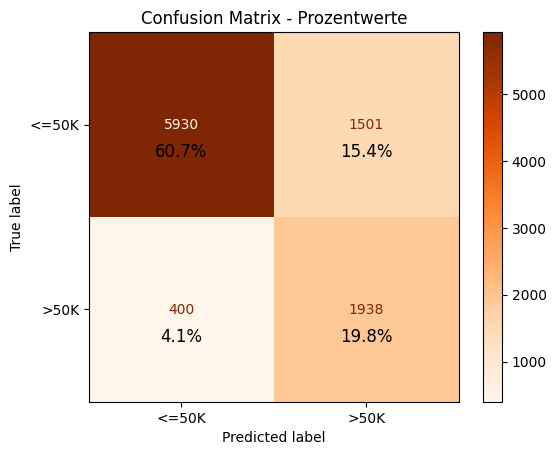

In [30]:
cm = confusion_matrix(y_test_income, y_pred_test, labels=[0,1])
cm_percent = cm / cm.sum() * 100  # Prozentwerte bezogen auf die gesamte Matrix

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(cm, display_labels=["<=50K", ">50K"])
disp.plot(cmap=plt.cm.Oranges, ax=ax, values_format="")  # Standardzahlen unterdrücken

# Nur Prozentzahlen hinzufügen, etwas tiefer in der Zelle, in weiß
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i + 0.15, f"{cm_percent[i,j]:.1f}%",
                ha='center', va='center', color='black', fontsize=12)


plt.title("Confusion Matrix - Prozentwerte")
plt.show()


#### confusion Matrix der Subgruppen

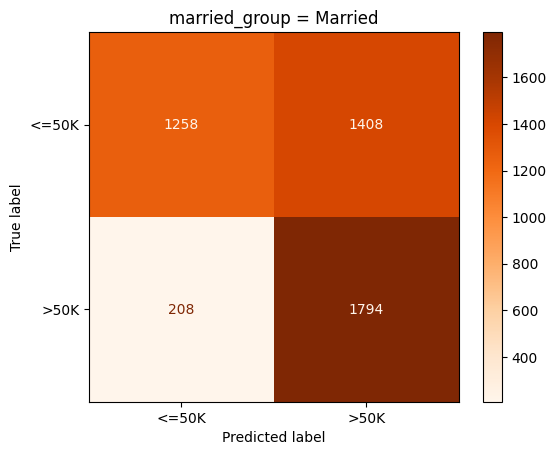

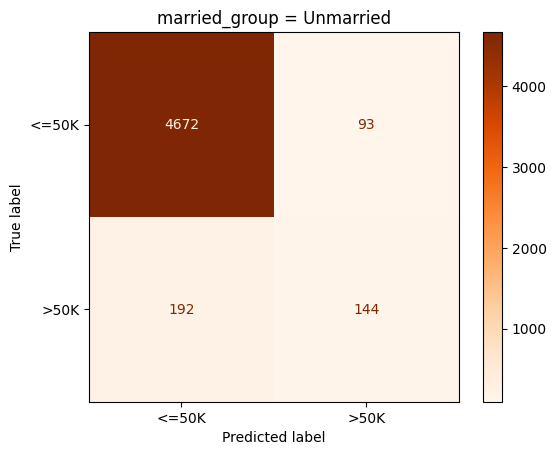

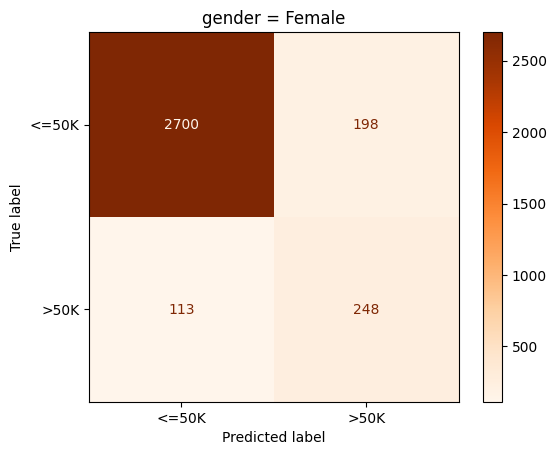

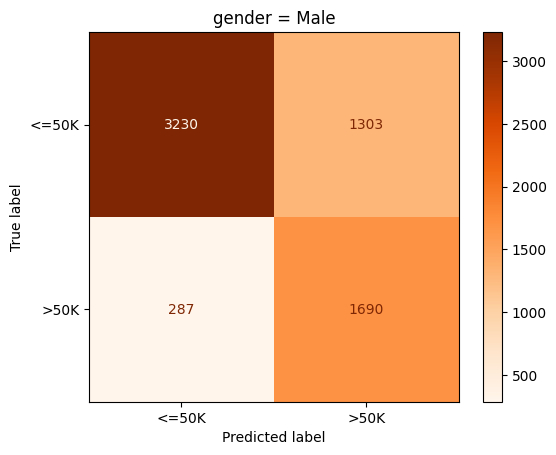

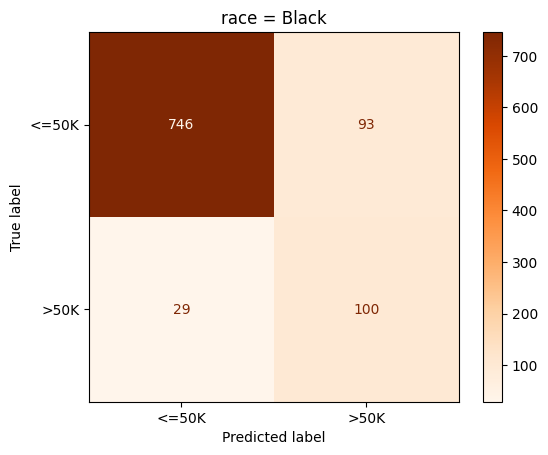

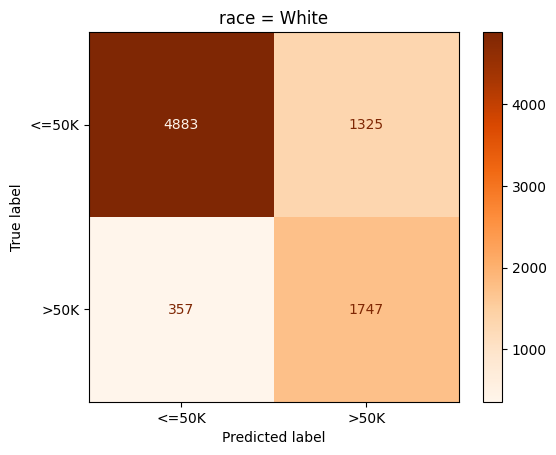

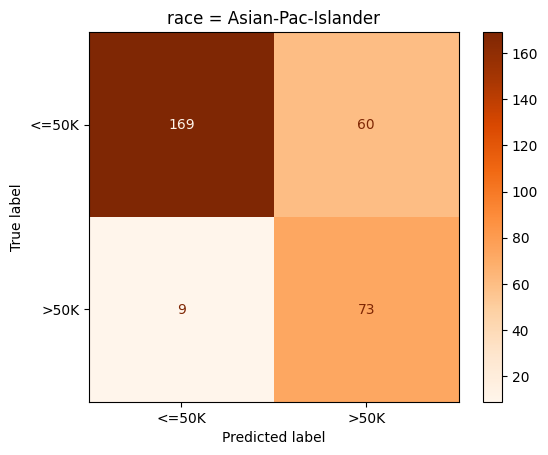

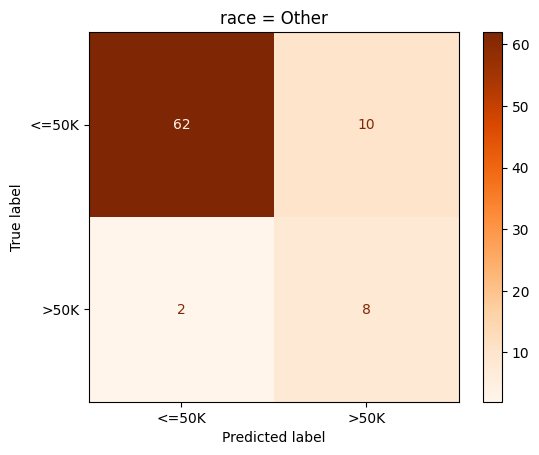

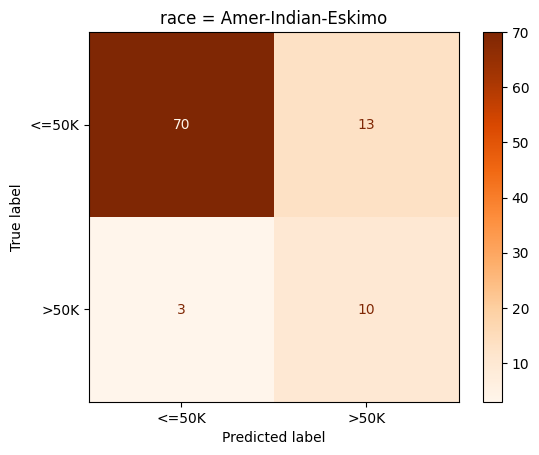

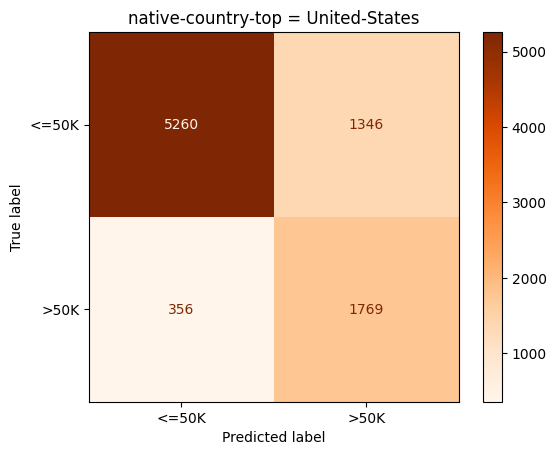

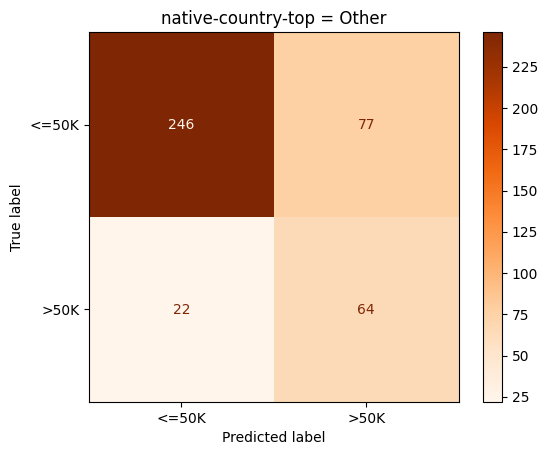

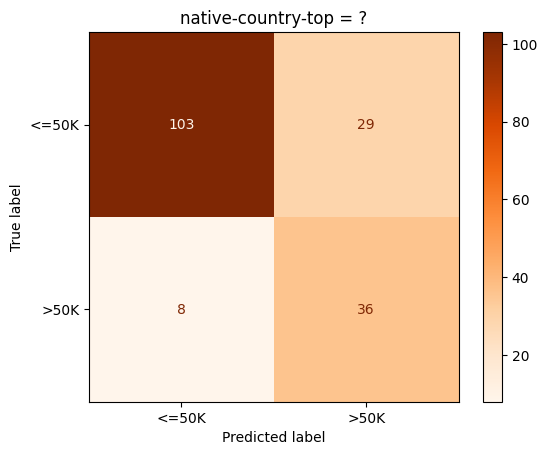

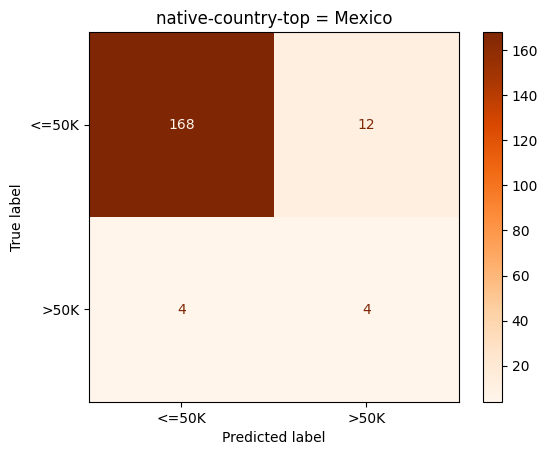

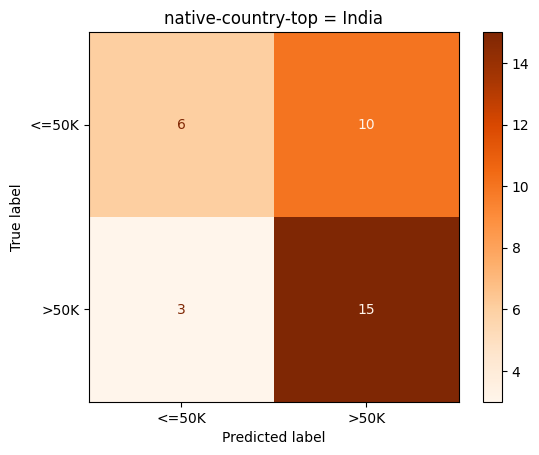

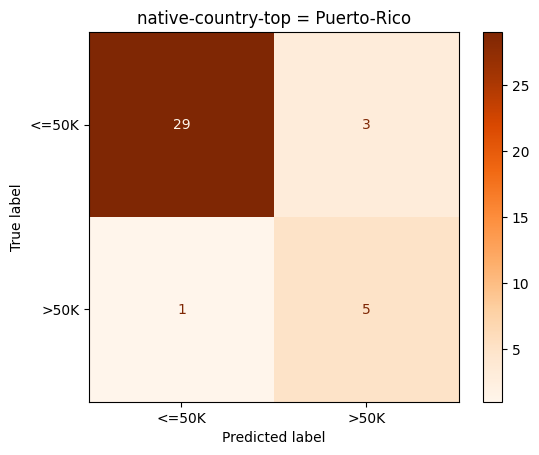

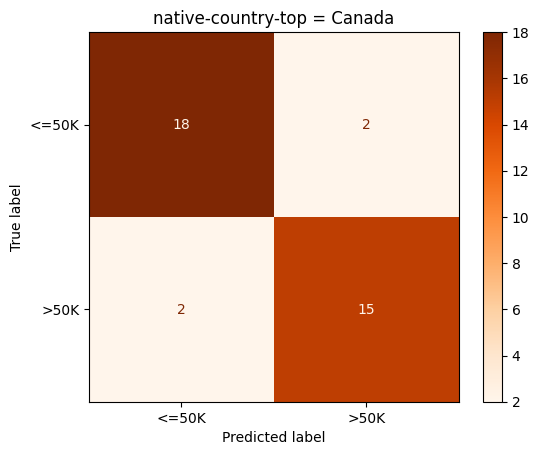

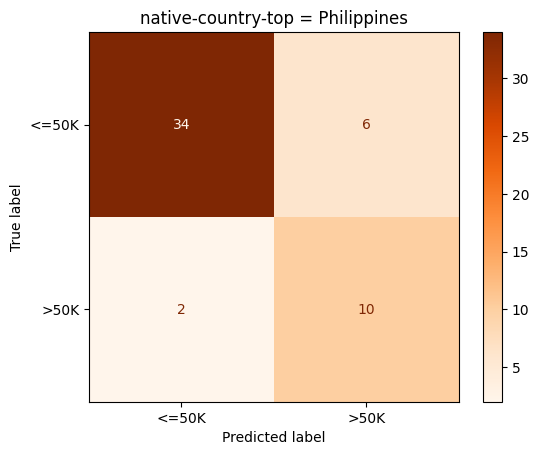

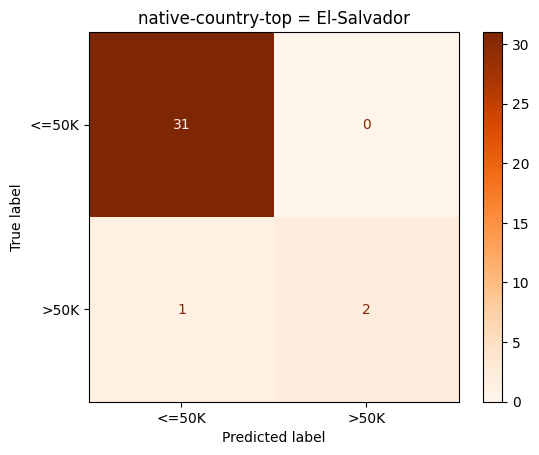

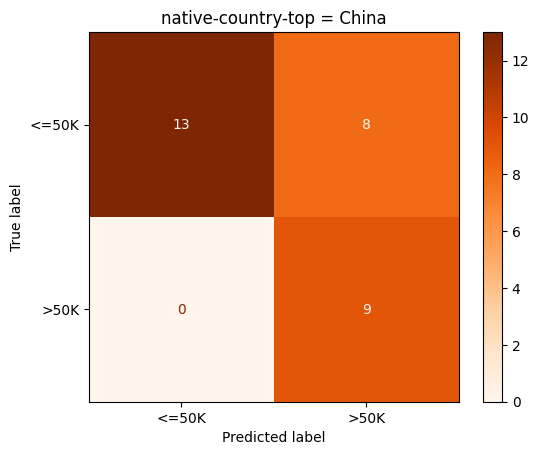

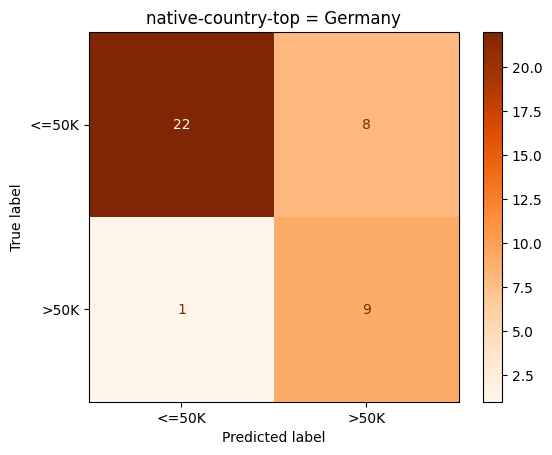

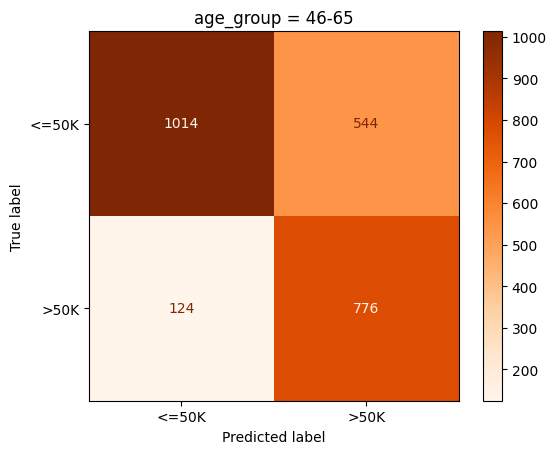

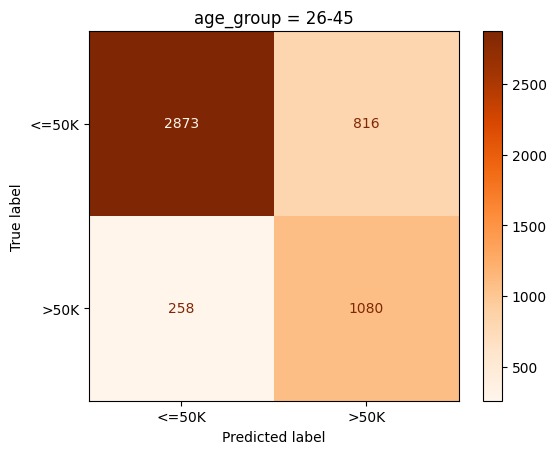

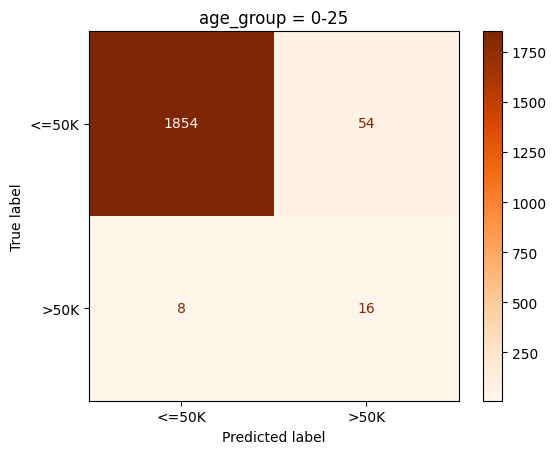

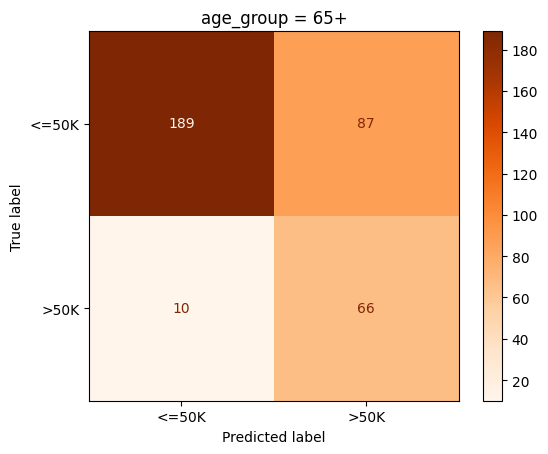

In [31]:
# Altersgruppen definieren
age_bins = pd.cut(df_income_test["age"], bins=[0,25,45,65,200], labels=["0-25","26-45","46-65","65+"])
df_income_test["age_group"] = age_bins

# Nur die Top 10 Länder betrachten
top_countries = df_income_test["native-country"].value_counts().head(10).index
df_income_test["native-country-top"] = df_income_test["native-country"].apply(lambda x: x if x in top_countries else "Other")

# untersuchende Features
features = ["married_group","gender", "race", "native-country-top", "age_group"]

for feat in features:
    for val in df_income_test[feat].unique():
        mask = df_income_test[feat] == val
        cm = confusion_matrix(
            y_test_income[mask],
            y_pred_test[mask],
            labels=[0,1]
        )
        disp = ConfusionMatrixDisplay(cm, display_labels=["<=50K", ">50K"])
        disp.plot(cmap=plt.cm.Oranges)
        plt.title(f"{feat} = {val}")
        plt.show()

#### Accuracy, FP, FN als Tabelle

In [32]:
# Sicherheitskopie
df_income_test = df_income_test.copy()

# Altersgruppen hinzufügen
df_income_test["age_group"] = pd.cut(
    df_income_test["age"],
    bins=[0, 25, 45, 65, 200],
    labels=["0-25", "26-45", "46-65", "65+"]
)

# Vorhersagen in Pandas Series umwandeln, falls NumPy-Arrays
y_test_income = pd.Series(y_test_income, index=df_income_test.index)
y_pred_test = pd.Series(y_pred_test, index=df_income_test.index)

# Features, die untersucht werden sollen
features_to_check = ["married_group", "gender", "race", "native-country", "age_group"]

# Ergebnisse speichern
results = []

for feat in features_to_check:
    print(f"\nAnalyse für Feature: {feat}")

    for subgroup in df_income_test[feat].dropna().unique():
        mask = df_income_test[feat] == subgroup

        # Reale Werte + Vorhersagen für diese Gruppe
        y_true_sub = y_test_income.loc[mask]
        y_pred_sub = y_pred_test.loc[mask]

        # kleine Gruppen überspringen
        if len(y_true_sub) < 20:
            continue

        # Confusion-Matrix sicher entpacken
        cm = confusion_matrix(y_true_sub, y_pred_sub, labels=[0,1])
        tn, fp, fn, tp = (cm.flatten().tolist() + [0, 0, 0, 0])[:4]

        # Schutz vor Division durch 0
        fp_rate = fp / (fp + tn) * 100 if (fp + tn) > 0 else 0
        fn_rate = fn / (fn + tp) * 100 if (fn + tp) > 0 else 0

        acc = accuracy_score(y_true_sub, y_pred_sub) * 100

        results.append({
            "Feature": feat,
            "Subgruppe": subgroup,
            "Samples": len(y_true_sub),
            "Accuracy (%)": round(acc, 2),
            "False Positives (%)": round(fp_rate, 2),
            "False Negatives (%)": round(fn_rate, 2)
        })

# Ergebnisse in DataFrame
results_df = pd.DataFrame(results)

# Schön sortiert ausgeben
pd.set_option('display.max_rows', None)
display(results_df.sort_values(["Feature", "Accuracy (%)"], ascending=[True, False]))


Analyse für Feature: married_group

Analyse für Feature: gender

Analyse für Feature: race

Analyse für Feature: native-country

Analyse für Feature: age_group


,Feature,Subgruppe,Samples,Accuracy (%),False Positives (%),False Negatives (%)
29,age_group,0-25,1932,96.79,2.83,33.33
28,age_group,26-45,5027,78.64,22.12,19.28
27,age_group,46-65,2458,72.82,34.92,13.78
30,age_group,65+,352,72.44,31.52,13.16
2,gender,Female,3259,90.46,6.83,31.30
3,gender,Male,6510,75.58,28.74,14.52
1,married_group,Unmarried,5101,94.41,1.95,57.14
0,married_group,Married,4668,65.38,52.81,10.39
18,native-country,El-Salvador,34,97.06,0.00,33.33
11,native-country,Mexico,188,91.49,6.67,50.00


#### trainierte-Modell als Gleichung bzw. gewichtung ansehen

In [33]:
# Feature-Namen aus Preprocessing
feature_names = preprocessing.get_feature_names_out()

# Gewichte + Bias ausgeben
for name, coef in zip(feature_names, model_lr.coef_[0]):
    print(f"{name}: {coef:.4f}")

print("Intercept (Bias):", model_lr.intercept_[0])

print()
print()

# Und jetzt als wirkliche "Gleichung"
eq = " + ".join([f"{coef:.4f}*{name}" for name, coef in zip(feature_names, model_lr.coef_[0])])
eq = f"logit(p) = {eq} + {model_lr.intercept_[0]:.4f}"
print(eq)

cat__workclass_?: -0.2374
cat__workclass_Federal-gov: 0.6053
cat__workclass_Local-gov: -0.1221
cat__workclass_Never-worked: -0.0796
cat__workclass_Private: 0.0810
cat__workclass_Self-emp-inc: 0.2746
cat__workclass_Self-emp-not-inc: -0.3780
cat__workclass_State-gov: -0.3309
cat__workclass_Without-pay: -0.3483
cat__education_10th: -0.1191
cat__education_11th: -0.3873
cat__education_12th: -0.2876
cat__education_1st-4th: 0.2162
cat__education_5th-6th: 0.2748
cat__education_7th-8th: -0.0487
cat__education_9th: 0.1158
cat__education_Assoc-acdm: -0.1845
cat__education_Assoc-voc: -0.0874
cat__education_Bachelors: -0.0202
cat__education_Doctorate: 0.0146
cat__education_HS-grad: -0.0188
cat__education_Masters: 0.0107
cat__education_Preschool: -0.3052
cat__education_Prof-school: 0.2369
cat__education_Some-college: 0.0545
cat__occupation_?: -0.3169
cat__occupation_Adm-clerical: 0.1379
cat__occupation_Armed-Forces: 0.1509
cat__occupation_Craft-repair: 0.2525
cat__occupation_Exec-managerial: 0.9793


In [34]:
# DataFrame mit Feature-Namen und Gewichten
weights_df = pd.DataFrame({
    "Feature": feature_names,
    "Weight": model_lr.coef_[0],
})

# Absoluter Betrag = Stärke des Einflusses (egal ob positiv oder negativ)
weights_df["Abs Weight"] = np.abs(weights_df["Weight"])

# Nach Einfluss sortieren
weights_df = weights_df.sort_values("Abs Weight", ascending=False)

# Top 10 wichtigsten Features
print("Top 10 wichtigste Features:")
print(weights_df.head(10))

# (Optional) Kleinste Gewichte (also unwichtige Features)
print("\nAm wenigsten einflussreiche Features:")
print(weights_df.tail(10))

Top 10 wichtigste Features:
                            Feature    Weight  Abs Weight
44          remainder__capital-gain  2.305402    2.305402
34  cat__occupation_Priv-house-serv -1.989291    1.989291
41     cat__married_group_Unmarried -1.558212    1.558212
40       cat__married_group_Married  1.022883    1.022883
29  cat__occupation_Exec-managerial  0.979251    0.979251
30  cat__occupation_Farming-fishing -0.905510    0.905510
36  cat__occupation_Protective-serv  0.793500    0.793500
33    cat__occupation_Other-service -0.752317    0.752317
43       remainder__educational-num  0.729994    0.729994
35   cat__occupation_Prof-specialty  0.720073    0.720073

Am wenigsten einflussreiche Features:
                              Feature    Weight  Abs Weight
4              cat__workclass_Private  0.081004    0.081004
3         cat__workclass_Never-worked -0.079590    0.079590
32  cat__occupation_Machine-op-inspct -0.073532    0.073532
24        cat__education_Some-college  0.054518    0.05